# Model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import cv2
import csv

In [2]:
tf.keras.backend.set_image_data_format('channels_last')

In [3]:
train_path = './data/train/'
valid_path = './data/valid'
test_path = './data/test'

In [4]:
train_csv = './data/train.csv'
valid_csv = './data/valid.csv'
test_csv = './data/test.csv'

### Pre-processing Data

In [5]:
def append_ext(fn):    # Helper function to append extention name for image id
    return fn + ".jpg"

In [7]:
train_df = pd.read_csv(train_csv)

In [8]:
train_df

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix
...,...,...
5503,5f0c970adf,lampropeltis-triangulum
5504,f6a4287fac,pantherophis-alleghaniensis
5505,d3c10e63e1,thamnophis-sirtalis
5506,61ef50879c,pituophis-catenifer


In [7]:
train_df["image_id"] = train_df["image_id"].apply(append_ext)

In [8]:
valid_df["image_id"] = valid_df["image_id"].apply(append_ext)

In [9]:
test_df["image_id"] = test_df["image_id"].apply(append_ext)

In [11]:
IMG_DIM=224
bs = 64

In [12]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.5, 1.0],
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
)

In [13]:
train_batches = datagen.flow_from_dataframe(
    train_df,
    directory=train_path,
    target_size=(IMG_DIM,IMG_DIM),
    x_col="image_id",
    y_col="breed",
    batch_size=bs
)

Found 4958 validated image filenames belonging to 35 classes.


In [ ]:
valid_batches = datagen.flow_from_dataframe(
    valid_df, 
    directory=train_path,
    target_size=(IMG_DIM, IMG_DIM),
    x_col = "image_id",
    y_col = "breed",
    batch_size = bs
)

### Sample Image preview

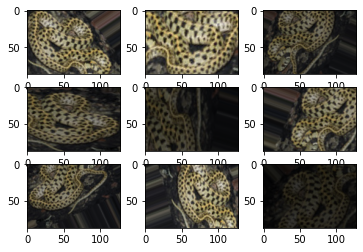

In [15]:
img = load_img("./data/train/0002023e6f.jpg")     # Sample Image
data = img_to_array(img)

samples = np.expand_dims(data, 0)

it = datagen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

## Transfer Learning using VGG16


In [3]:
NAME = "vgg16withLastUnfrozen"

In [5]:
vgg = tf.keras.applications.vgg16.VGG16()

In [6]:
model = Sequential()

In [7]:
for layer in vgg.layers[:-1]:
    model.add(layer)

In [8]:
for layer in model.layers:
    layer.trainable = False

### VGG16 with last 4 layers trainable

In [2]:
ep =30

In [86]:
NAME="VGG16WithLast4Frozzen"

In [87]:
vgg = tf.keras.applications.vgg16.VGG16()

In [88]:
model = Sequential()

In [89]:
for layer in vgg.layers[:-1]:
    model.add(layer)
for layer in model.layers[:-5]:
    layer.trainable = False

In [90]:
# Dense
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

#Output
model.add(Dense(35, activation="softmax"))

In [91]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(
    x=train_batches,
    steps_per_epoch= train_batches.n // train_batches.batch_size,
    validation_data= valid_batches,
    validation_steps= valid_batches.n // valid_batches.batch_size,
    epochs=ep
)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
154/154 [==============================] - ETA: 0s - loss: 3.5051 - accuracy: 0.0926WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B0192A8CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

In [ ]:
model.save(NAME)

## Prediction

Helper function to convert the test data into a readable format

In [ ]:

def create_test_data():
    images = []      # List contains path of all the testing images in right seq
    test_data = []
    df = pd.read_csv(test_csv)    # Path to test csv file
    names_df = df["image_id"].apply(append_ext)    # Adding jpg exten to the image name
    for img in names_df:
        img_path = os.path.join(test_path, img)
        images.append(img_path)
    for img_path in images:
        try:
            img_array = cv2.imread(img_path, cv2.COLOR_BGR2RGB)   # convert to img to arr
            new_array = cv2.resize(img_array, (224, 224))  # resize to same format
            test_data.append(new_array.reshape(224, 224, 3))     
        except Exception as e:
            pass
        
        return test_data

    
test_data = np.array(create_test_data())    # Convert the returned array to numpy arr

    
    
    
    


In [ ]:
prediction = model.predict(test_data)

In [ ]:
results = []
for i in prediction:
    result.append(np.argmax(i))

A function to save the predictions to the csv file format req


In [ ]:
def save_results(results):
    images = pd.read_csv(test_csv)["image_id"]
    with open("results.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["image_id", "breed"])
        for i in range(len(images)):
            res = str(cats[results[i]])
            img = images[i]
            w.writerow([img, res])
save_results(results)

### Prediction


Helper function to onvert the testing images into readable format

In [23]:

def create_test_data():
    images = []       # List containes path of all the testing images in right seq
    test_data = []    
    df = pd.read_csv(test_csv)
    names_df = df['image_id'].apply(append_ext)
    for img in names_df:
        img_path = os.path.join(test_path, img)
        images.append(img_path)        
    for img_path in images:
        try:
            img_array = cv2.imread(img_path ,cv2.COLOR_BGR2RGB)  # convert to array
            new_array = cv2.resize(img_array, (224, 224))  # resize to normalize data size
            test_data.append(new_array.reshape(224, 224, 3))  # add this to our training_data

        except Exception as e:
            print("Error !!")
            print(e)
            pass
    return test_data
test_data = np.array(create_test_data())
print(test_data.shape)

(2361, 224, 224, 3)


In [47]:
prediction = model.predict(test_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [24]:
results = []
for i in prediction:
    results.append(np.argmax(i))
results[:5]

NameError: name 'prediction' is not defined

In [51]:
test_df = pd.read_csv(test_csv)
test_df[:5]

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


In [63]:
cats = train_batches.class_indices.keys()
cats = list(cats)
cats

['agkistrodon-contortrix',
 'agkistrodon-piscivorus',
 'coluber-constrictor',
 'crotalus-atrox',
 'crotalus-horridus',
 'crotalus-ruber',
 'crotalus-scutulatus',
 'crotalus-viridis',
 'diadophis-punctatus',
 'haldea-striatula',
 'heterodon-platirhinos',
 'lampropeltis-californiae',
 'lampropeltis-triangulum',
 'masticophis-flagellum',
 'natrix-natrix',
 'nerodia-erythrogaster',
 'nerodia-fasciata',
 'nerodia-rhombifer',
 'nerodia-sipedon',
 'opheodrys-aestivus',
 'pantherophis-alleghaniensis',
 'pantherophis-emoryi',
 'pantherophis-guttatus',
 'pantherophis-obsoletus',
 'pantherophis-spiloides',
 'pantherophis-vulpinus',
 'pituophis-catenifer',
 'rhinocheilus-lecontei',
 'storeria-dekayi',
 'storeria-occipitomaculata',
 'thamnophis-elegans',
 'thamnophis-marcianus',
 'thamnophis-proximus',
 'thamnophis-radix',
 'thamnophis-sirtalis']

In [22]:
def save_results(results):
    images = pd.read_csv(test_csv)["image_id"]
    with open("results.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["image_id", "breed"])
        for i in range(len(images)):
            res = str(cats[results[i]])
            img = images[i]
            w.writerow([img, res])
save_results(results)

NameError: name 'results' is not defined

## VGG With last 5 trainable layers and learning rate = 3e-4

In [47]:
NAME="VGG16WithLast5UnFrozzenAndLr3e-4"

In [48]:
vgg = tf.keras.applications.vgg16.VGG16()

In [49]:
model = Sequential()

In [50]:
for layer in vgg.layers[:-1]:
    model.add(layer)
for layer in model.layers[:-5]:
    layer.trainable = False

In [51]:
# Dense
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

#Output
model.add(Dense(35, activation="softmax"))

In [52]:
model.compile(optimizer=Adam(learning_rate=3e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [53]:
valid_batches.batch_size

64

In [54]:
model.fit(
    x=train_batches,
    steps_per_epoch= train_batches.n // train_batches.batch_size,
    validation_data= valid_batches,
    validation_steps= valid_batches.n // valid_batches.batch_size,
    epochs=ep
)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
77/77 [==============================] - ETA: 0s - loss: 3.4723 - accuracy: 0.0954 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000026F9DD65288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

In [55]:
model.save(NAME)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: VGG16WithLast5UnFrozzenAndLr3e-4\assets


In [57]:
prediction = model.predict(test_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [58]:
results = []
for i in prediction:
    results.append(np.argmax(i))
results[:5]

[23, 1, 23, 8, 20]

In [60]:
cats = train_batches.class_indices.keys()
cats = list(cats)

In [61]:
def save_results(results):
    images = pd.read_csv(test_csv)["image_id"]
    with open("results-new.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["image_id", "breed"])
        for i in range(len(images)):
            res = str(cats[results[i]])
            img = images[i]
            w.writerow([img, res])
save_results(results)

## Loaded model

Here I will load a pre trained and fine tuned model and reduce the learning rate and epochs

In [17]:
model = load_model("./saved-models/VGG16WithLast5UnFrozzenAndLr3e-4/")

In [18]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [19]:
model.fit(
    x=train_batches,
    steps_per_epoch= train_batches.n // train_batches.batch_size,
    validation_data= valid_batches,
    validation_steps= valid_batches.n // valid_batches.batch_size,
    epochs=5
)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
77/77 [==============================] - ETA: 0s - loss: 2.5681 - accuracy: 0.2965 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001F8001EFAF8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

In [20]:
model.save("VggTrainedFurther1e-5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: VggTrainedFurther1e-5\assets


In [25]:
prediction = model.predict(test_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
results = []
for i in prediction:
    results.append(np.argmax(i))
results[:5]

[34, 1, 23, 8, 26]

In [27]:
cats = train_batches.class_indices.keys()
cats = list(cats)

In [28]:
def save_results(results):
    images = pd.read_csv(test_csv)["image_id"]
    with open("results-latest.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["image_id", "breed"])
        for i in range(len(images)):
            res = str(cats[results[i]])
            img = images[i]
            w.writerow([img, res])
save_results(results)